In [1]:
# !nvidia-smi

In [2]:
# !pip install diffusers accelerate transformers opencv-contrib-python

In [3]:
# from huggingface_hub import notebook_login

# notebook_login()

In [4]:
import torch
import os
from pathlib import Path
from diffusers.utils import load_image
import numpy as np
import cv2
import PIL

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

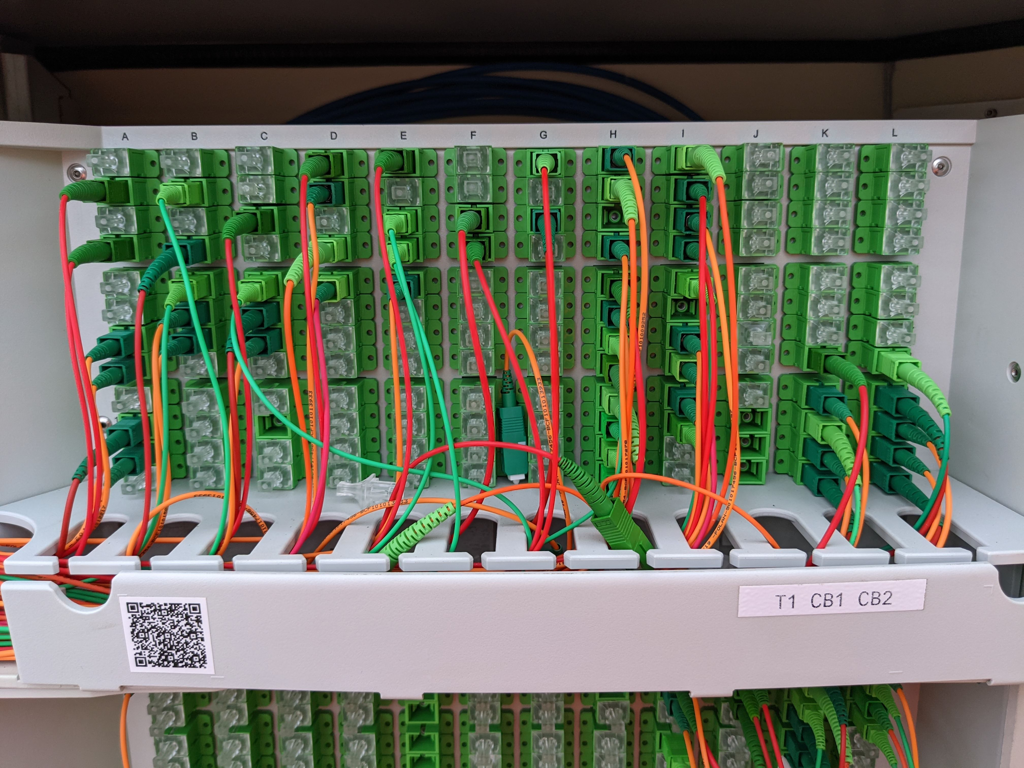

In [5]:
# image = load_image(
#     "https://huggingface.co/lllyasviel/control_v11p_sd15_canny/resolve/main/images/input.png"
# )
folder_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_dir = os.path.join(folder_path, "dataset", "raw_data", "images")
image = PIL.Image.open(os.path.join(image_dir, "000.jpg"))
image = image.resize((1024, 768))
image

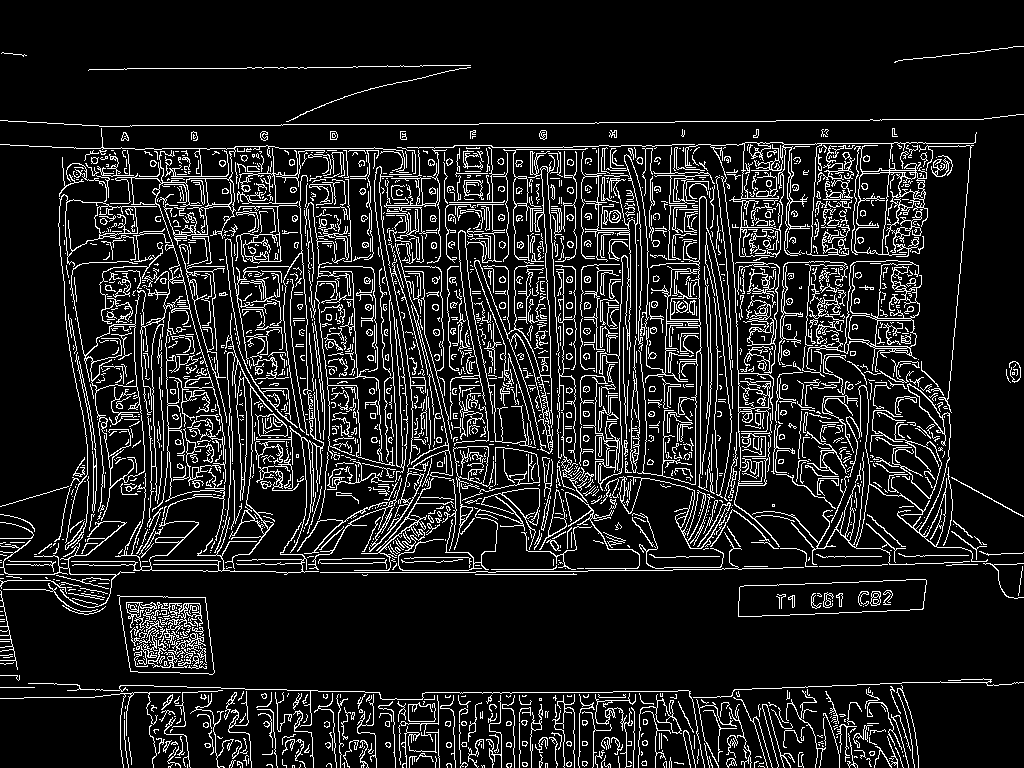

In [6]:
low_threshold = 100
high_threshold = 200

image = np.array(image)
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = PIL.Image.fromarray(image)
control_image

# control_image.save("./images/control.png")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

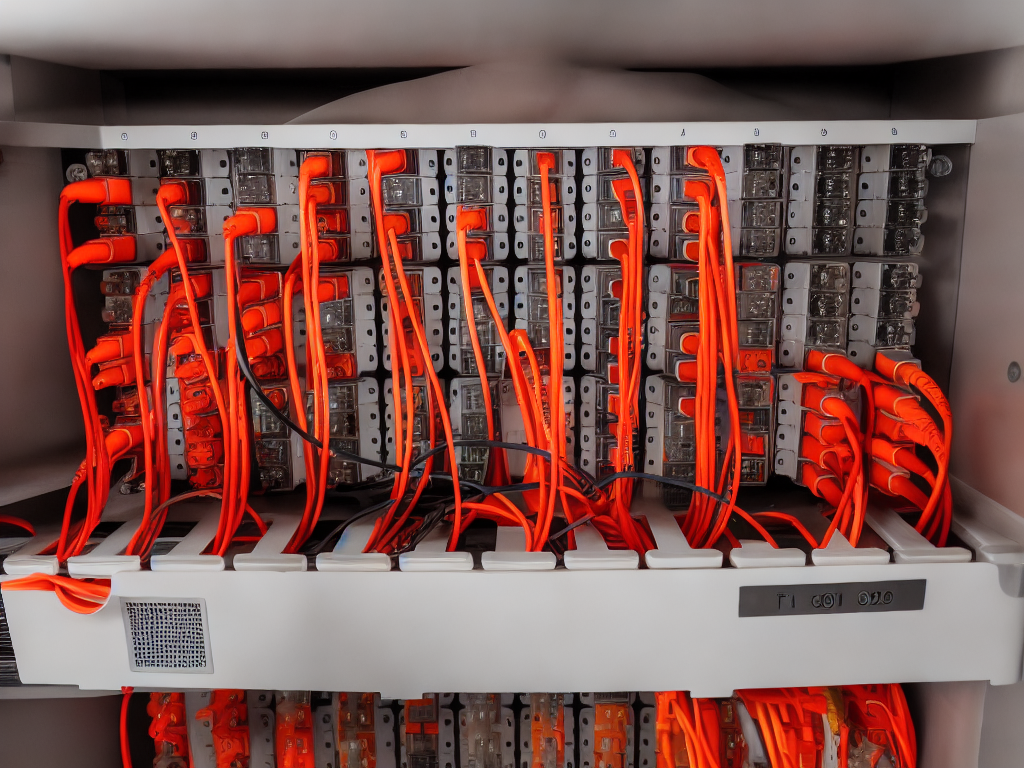

In [7]:
checkpoint_controlnet = "lllyasviel/control_v11p_sd15_canny"
checkpoint_diffusion = "runwayml/stable-diffusion-v1-5"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


controlnet = ControlNetModel.from_pretrained(checkpoint_controlnet, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    checkpoint_diffusion, controlnet=controlnet, torch_dtype=torch.float16
)
pipe = pipe.to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

prompt = "A cabinet filled with orange, red and white cables, each cable in one color"
generator = torch.manual_seed(33)
image = pipe(prompt, num_inference_steps=20, generator=generator, image=control_image).images[0]
image

# image.save('images/image_out.png')